In [54]:
from tensorly.decomposition.candecomp_parafac import *
# from tensorly.decomposition import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF,non_negative_factorization
from tensorly.kruskal_tensor import *
from glob import glob 


df_test = pd.read_csv('./PARAFAC implementation/Testing Data/K036VRÁS-RS211.csv',index_col=0)
df_test.index = pd.DatetimeIndex(df_test.CTime)
df_test = df_test.loc[df_test.OkPct >= 98]
df_test = df_test.loc[df_test.Flag == 524480]


x = df_test.loc[(df_test.CType == 4) & (df_test.Val > 0),:].Val
x = x.resample('1h').mean()
x = x.fillna(method='ffill')
weekhour_index = x.index.weekday * 24 + x.index.hour
first_0 = np.argwhere(weekhour_index == 0)[0,0]
last_0 = np.argwhere(weekhour_index == 0)[-1,0]
x = x.iloc[first_0:last_0]
X = x.values.reshape((-1,7*24))

In [13]:
from nonnegfac.nmf import NMF
W, H, info = NMF().run(A, 10)


In [16]:
W, H, info = NMF_HALS().run(X, 10,max_iter=None,)

[NMF] Running: 
{
    "A_dim_1": 683,
    "A_dim_2": 168,
    "A_type": "<class 'numpy.ndarray'>",
    "alg": "<class 'nonnegfac.nmf.NMF_HALS'>",
    "init": "uniform_random",
    "k": 10,
    "max_iter": 100,
    "max_time": Infinity,
    "verbose": 0
}
[NMF] Completed: 
{
    "elapsed": 0.11797451972961426,
    "iterations": 100,
    "norm_A": 848.4742080335567,
    "rel_error": 0.08526111744048075
}


In [30]:
errors = []
for i in range(1,50):
    W, H, info = NMF_HALS().run(X, i,max_iter=None,verbose=-1)
    tmp_error = info['final']['rel_error']
    errors.append(tmp_error)

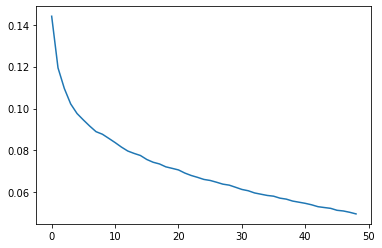

In [31]:
plt.plot(errors)

FileNotFoundError: [Errno 2] No such file or directory: '../../img/pca-crossval/pca_cv_curve.pdf'

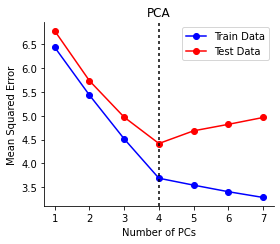

In [38]:
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from nonnegfac.nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

def censored_lstsq(A, B, M):
    """Solves least squares problem with missing data in B
    Note: uses a broadcasted solve for speed.
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """

    if A.ndim == 1:
        A = A[:,None]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    try:
        # transpose to get r x n
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
    except:
        r = T.shape[1]
        T[:,np.arange(r),np.arange(r)] += 1e-6
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T

def censored_nnlstsq(A, B, M):
    """Solves nonnegative least-squares problem with missing data in B
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : nonnegative r x n matrix that minimizes norm(M*(AX - B))
    """
    if A.ndim == 1:
        A = A[:,None]
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    X = np.empty((B.shape[1], A.shape[1]))
    for n in range(B.shape[1]):
        X[n] = nnlstsq(T[n], rhs[n], is_input_prod=True)[0].T
    return X.T

def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False):
    """Fit PCA or NMF while holding out a fraction of the dataset.
    """

    # choose solver for alternating minimization
    if nonneg:
        solver = censored_nnlstsq
    else:
        solver = censored_lstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    if nonneg:
        U = np.random.rand(data.shape[0], rank)
    else:
        U = np.random.randn(data.shape[0], rank)

    # fit pca/nmf
    for itr in range(50):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err


def cv_kmeans(data, rank, p_holdout=.3, M=None):
    """Fit kmeans while holding out a fraction of the dataset.
    """

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize cluster centers
    Vt = np.random.randn(rank, data.shape[1])
    U = np.empty((data.shape[0], rank))
    rn = np.arange(U.shape[0])

    # initialize missing data randomly
    imp = data.copy()
    imp[~M] = np.random.randn(*data.shape)[~M]

    # initialize cluster centers far apart
    Vt = [imp[np.random.randint(data.shape[0])]]
    while len(Vt) < rank:
        i = np.argmax(np.min(cdist(imp, Vt), axis=1))
        Vt.append(imp[i])
    Vt = np.array(Vt)

    # fit kmeans
    for itr in range(50):
        # update cluster assignments
        clus = np.argmin(cdist(imp, Vt), axis=1)
        U.fill(0.0)
        U[rn, clus] = 1.0
        # update centroids
        Vt = censored_lstsq(U, imp, M)
        assert np.all(np.sum(np.abs(Vt), axis=1) > 0)
        # update estimates of missing data
        imp[~M] = np.dot(U, Vt)[~M]

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return clus, U, Vt, train_err, test_err


def plot_pca():
    # parameters
    N, R = 150, 4
    noise = 2
    replicates = 1
    ranks = np.arange(1, 8)

    # initialize
    U = np.random.randn(N, R)
    Vt = np.random.randn(R, N)
    data = np.dot(U, Vt) + noise*np.random.randn(N, N)
    train_err, test_err = [], []

    # fit models
    for rnk, _ in itertools.product(ranks, range(replicates)):
        tr, te = cv_pca(data, rnk)[2:]
        train_err.append((rnk, tr))
        test_err.append((rnk, te))

    # make plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
    ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of PCs')
    ax.set_title('PCA')
    ax.axvline(4, color='k', dashes=[2,2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.tight_layout()
    fig.savefig('../../img/pca-crossval/pca_cv_curve.pdf')

def plot_nmf():
    # parameters
    N, R = 150, 4
    noise = .8
    replicates = 1
    ranks = np.arange(1, 8)

    # initialize problem
    U = np.random.rand(N, R)
    Vt = np.random.rand(R, N)
    data = np.dot(U, Vt) + noise*np.random.rand(N, N)
    train_err, test_err = [], []

    # fit models
    for rnk, _ in itertools.product(ranks, range(replicates)):
        tr, te = cv_pca(data, rnk, nonneg=True)[2:]
        train_err.append((rnk, tr))
        test_err.append((rnk, te))

    # make plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
    ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of factors')
    ax.set_title('NMF')
    ax.axvline(4, color='k', dashes=[2,2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.tight_layout()
    fig.savefig('../../img/pca-crossval/nmf_cv_curve.pdf')

def plot_kmeans():
    # parameters
    N, R = 150, 4
    noise = 1.5
    ranks = np.arange(1, 8)
    replicates = 10

    # initialize problem
    U = np.zeros((N, R))
    U[np.arange(N), np.random.randint(R, size=N)] = 1
    Vt = np.random.randn(R, N)
    data = np.dot(U, Vt) + noise*np.random.randn(N, N)
    train_err, test_err, rr = [], [], []

    # fit models
    for rnk, _ in itertools.product(ranks, range(replicates)):
        tr, te = cv_kmeans(data, rnk)[3:]
        train_err.append(tr)
        test_err.append(te)
        rr.append(rnk)

    rr = np.array(rr)
    train_err, test_err = np.array(train_err), np.array(test_err)
    mean_train = [np.mean(train_err[rr==rnk]) for rnk in ranks]
    mean_test = [np.mean(test_err[rr==rnk]) for rnk in ranks]

    # make plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.plot(ranks, mean_train, '-b', label='Train Data')
    ax.plot(ranks, mean_test, '-r', label='Test Data')
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Number of clusters')
    ax.set_title('K-means clustering')
    ax.axvline(4, color='k', dashes=[2,2])
    ax.plot(rr, train_err, 'ob', alpha=.5, ms=3, mec=None)
    ax.plot(rr, test_err, 'or', alpha=.5, ms=3, mec=None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    fig.tight_layout()
    fig.savefig('../../img/pca-crossval/kmeans_cv_curve.pdf')


if __name__ == '__main__':
    plot_pca()
    plot_nmf()
    plot_kmeans()
    plt.show()
nnls.py
"""
Code for nonnegative least squares by block-pivoting.
"""
import numpy as np
import scipy.optimize as opt
import scipy.sparse as sps
import numpy.linalg as nla
import scipy.linalg as sla
import time

"""
The remaining code in this file was written and shared by Jingu Kim (@kimjingu).
REPO:
----
https://github.com/kimjingu/nonnegfac-python
LICENSE:
-------
Copyright (c) 2014, Nokia Corporation
All rights reserved.
Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:
    * Redistributions of source code must retain the above copyright
      notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright
      notice, this list of conditions and the following disclaimer in the
      documentation and/or other materials provided with the distribution.
    * Neither the name of the Nokia Corporation nor the
      names of its contributors may be used to endorse or promote products
      derived from this software without specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL NOKIA CORPORATION BE LIABLE FOR ANY
DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""

def nnlsm_blockpivot(A, B, is_input_prod=False, init=None):
    """ Nonnegativity-constrained least squares with block principal pivoting method and column grouping
    Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
    J. Kim and H. Park, Fast nonnegative matrix factorization: An active-set-like method and comparisons,
    SIAM Journal on Scientific Computing, 
    vol. 33, no. 6, pp. 3261-3281, 2011.
    Parameters
    ----------
    A : numpy.array, shape (m,n)
    B : numpy.array or scipy.sparse matrix, shape (m,k)
    Optional Parameters
    -------------------
    is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
            AtA and AtB, respectively. Default is False.
    init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
            Default is None.
    Returns
    -------
    X, (success, Y, num_cholesky, num_eq, num_backup)
    X : numpy.array, shape (n,k) - solution
    success : True/False - True if the solution is found. False if the algorithm did not terminate
            due to numerical errors.
    Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
    num_cholesky : int - the number of Cholesky factorizations needed
    num_eq : int - the number of linear systems of equations needed to be solved
    num_backup: int - the number of appearances of the back-up rule. See SISC paper for details.
    """
    if is_input_prod:
        AtA = A
        AtB = B
    else:
        AtA = A.T.dot(A)
        if sps.issparse(B):
            AtB = B.T.dot(A)
            AtB = AtB.T
        else:
            AtB = A.T.dot(B)

    (n, k) = AtB.shape
    MAX_ITER = n * 5

    if init is not None:
        PassSet = init > 0
        X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB, PassSet)
        Y = AtA.dot(X) - AtB
    else:
        X = np.zeros([n, k])
        Y = -AtB
        PassSet = np.zeros([n, k], dtype=bool)
        num_cholesky = 0
        num_eq = 0

    p_bar = 3
    p_vec = np.zeros([k])
    p_vec[:] = p_bar
    ninf_vec = np.zeros([k])
    ninf_vec[:] = n + 1
    not_opt_set = np.logical_and(Y < 0, ~PassSet)
    infea_set = np.logical_and(X < 0, PassSet)

    not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
    not_opt_colset = not_good > 0
    not_opt_cols = not_opt_colset.nonzero()[0]

    big_iter = 0
    num_backup = 0
    success = True
    while not_opt_cols.size > 0:
        big_iter += 1
        if MAX_ITER > 0 and big_iter > MAX_ITER:
            success = False
            break

        cols_set1 = np.logical_and(not_opt_colset, not_good < ninf_vec)
        temp1 = np.logical_and(not_opt_colset, not_good >= ninf_vec)
        temp2 = p_vec >= 1
        cols_set2 = np.logical_and(temp1, temp2)
        cols_set3 = np.logical_and(temp1, ~temp2)

        cols1 = cols_set1.nonzero()[0]
        cols2 = cols_set2.nonzero()[0]
        cols3 = cols_set3.nonzero()[0]

        if cols1.size > 0:
            p_vec[cols1] = p_bar
            ninf_vec[cols1] = not_good[cols1]
            true_set = np.logical_and(not_opt_set, np.tile(cols_set1, (n, 1)))
            false_set = np.logical_and(infea_set, np.tile(cols_set1, (n, 1)))
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols2.size > 0:
            p_vec[cols2] = p_vec[cols2] - 1
            temp_tile = np.tile(cols_set2, (n, 1))
            true_set = np.logical_and(not_opt_set, temp_tile)
            false_set = np.logical_and(infea_set, temp_tile)
            PassSet[true_set] = True
            PassSet[false_set] = False
        if cols3.size > 0:
            for col in cols3:
                candi_set = np.logical_or(
                    not_opt_set[:, col], infea_set[:, col])
                to_change = np.max(candi_set.nonzero()[0])
                PassSet[to_change, col] = ~PassSet[to_change, col]
                num_backup += 1

        (X[:, not_opt_cols], temp_cholesky, temp_eq) = normal_eq_comb(
            AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols])
        num_cholesky += temp_cholesky
        num_eq += temp_eq
        X[abs(X) < 1e-12] = 0
        Y[:, not_opt_cols] = AtA.dot(X[:, not_opt_cols]) - AtB[:, not_opt_cols]
        Y[abs(Y) < 1e-12] = 0

        not_opt_mask = np.tile(not_opt_colset, (n, 1))
        not_opt_set = np.logical_and(
            np.logical_and(not_opt_mask, Y < 0), ~PassSet)
        infea_set = np.logical_and(
            np.logical_and(not_opt_mask, X < 0), PassSet)
        not_good = np.sum(not_opt_set, axis=0) + np.sum(infea_set, axis=0)
        not_opt_colset = not_good > 0
        not_opt_cols = not_opt_colset.nonzero()[0]

    return X, (success, Y, num_cholesky, num_eq, num_backup)


def nnlsm_activeset(A, B, overwrite=False, is_input_prod=False, init=None):
    """ Nonnegativity-constrained least squares with active-set method and column grouping
    Solves min ||AX-B||_2^2 s.t. X >= 0 element-wise.
    Algorithm of this routine is close to the one presented in the following paper but
    is different in organising inner- and outer-loops:
    M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
    Parameters
    ----------
    A : numpy.array, shape (m,n)
    B : numpy.array or scipy.sparse matrix, shape (m,k)
    Optional Parameters
    -------------------
    is_input_prod : True/False. -  If True, the A and B arguments are interpreted as
            AtA and AtB, respectively. Default is False.
    init: numpy.array, shape (n,k). - If provided, init is used as an initial value for the algorithm.
            Default is None.
    Returns
    -------
    X, (success, Y, num_cholesky, num_eq, num_backup)
    X : numpy.array, shape (n,k) - solution
    success : True/False - True if the solution is found. False if the algorithm did not terminate
            due to numerical errors.
    Y : numpy.array, shape (n,k) - Y = A.T * A * X - A.T * B
    num_cholesky : int - the number of Cholesky factorizations needed
    num_eq : int - the number of linear systems of equations needed to be solved
    """
    if is_input_prod:
        AtA = A
        AtB = B
    else:
        AtA = A.T.dot(A)
        if sps.issparse(B):
            AtB = B.T.dot(A)
            AtB = AtB.T
        else:
            AtB = A.T.dot(B)

    (n, k) = AtB.shape
    MAX_ITER = n * 5
    num_cholesky = 0
    num_eq = 0
    not_opt_set = np.ones([k], dtype=bool)

    if overwrite:
        X, num_cholesky, num_eq = normal_eq_comb(AtA, AtB)
        PassSet = X > 0
        not_opt_set = np.any(X < 0, axis=0)
    elif init != None:
        X = init
        X[X < 0] = 0
        PassSet = X > 0
    else:
        X = np.zeros([n, k])
        PassSet = np.zeros([n, k], dtype=bool)

    Y = np.zeros([n, k])
    opt_cols = (~not_opt_set).nonzero()[0]
    not_opt_cols = not_opt_set.nonzero()[0]

    Y[:, opt_cols] = AtA.dot(X[:, opt_cols]) - AtB[:, opt_cols]

    big_iter = 0
    success = True
    while not_opt_cols.size > 0:
        big_iter += 1
        if MAX_ITER > 0 and big_iter > MAX_ITER:
            success = False
            break

        (Z, temp_cholesky, temp_eq) = normal_eq_comb(
            AtA, AtB[:, not_opt_cols], PassSet[:, not_opt_cols])
        num_cholesky += temp_cholesky
        num_eq += temp_eq

        Z[abs(Z) < 1e-12] = 0

        infea_subset = Z < 0
        temp = np.any(infea_subset, axis=0)
        infea_subcols = temp.nonzero()[0]
        fea_subcols = (~temp).nonzero()[0]

        if infea_subcols.size > 0:
            infea_cols = not_opt_cols[infea_subcols]

            (ix0, ix1_subsub) = infea_subset[:, infea_subcols].nonzero()
            ix1_sub = infea_subcols[ix1_subsub]
            ix1 = not_opt_cols[ix1_sub]

            X_infea = X[(ix0, ix1)]

            alpha = np.zeros([n, len(infea_subcols)])
            alpha[:] = np.inf
            alpha[(ix0, ix1_subsub)] = X_infea / (X_infea - Z[(ix0, ix1_sub)])
            min_ix = np.argmin(alpha, axis=0)
            min_vals = alpha[(min_ix, range(0, alpha.shape[1]))]

            X[:, infea_cols] = X[:, infea_cols] + \
                (Z[:, infea_subcols] - X[:, infea_cols]) * min_vals
            X[(min_ix, infea_cols)] = 0
            PassSet[(min_ix, infea_cols)] = False

        elif fea_subcols.size > 0:
            fea_cols = not_opt_cols[fea_subcols]

            X[:, fea_cols] = Z[:, fea_subcols]
            Y[:, fea_cols] = AtA.dot(X[:, fea_cols]) - AtB[:, fea_cols]

            Y[abs(Y) < 1e-12] = 0

            not_opt_subset = np.logical_and(
                Y[:, fea_cols] < 0, ~PassSet[:, fea_cols])
            new_opt_cols = fea_cols[np.all(~not_opt_subset, axis=0)]
            update_cols = fea_cols[np.any(not_opt_subset, axis=0)]

            if update_cols.size > 0:
                val = Y[:, update_cols] * ~PassSet[:, update_cols]
                min_ix = np.argmin(val, axis=0)
                PassSet[(min_ix, update_cols)] = True

            not_opt_set[new_opt_cols] = False
            not_opt_cols = not_opt_set.nonzero()[0]

    return X, (success, Y, num_cholesky, num_eq)


def normal_eq_comb(AtA, AtB, PassSet=None):
    """ Solve many systems of linear equations using combinatorial grouping.
    M. H. Van Benthem and M. R. Keenan, J. Chemometrics 2004; 18: 441-450
    Parameters
    ----------
    AtA : numpy.array, shape (n,n)
    AtB : numpy.array, shape (n,k)
    Returns
    -------
    (Z,num_cholesky,num_eq)
    Z : numpy.array, shape (n,k) - solution
    num_cholesky : int - the number of unique cholesky decompositions done
    num_eq: int - the number of systems of linear equations solved
    """
    num_cholesky = 0
    num_eq = 0
    if AtB.size == 0:
        Z = np.zeros([])
    elif (PassSet is None) or np.all(PassSet):
        Z = nla.solve(AtA, AtB)
        num_cholesky = 1
        num_eq = AtB.shape[1]
    else:
        Z = np.zeros(AtB.shape)
        if PassSet.shape[1] == 1:
            if np.any(PassSet):
                cols = PassSet.nonzero()[0]
                Z[cols] = nla.solve(AtA[np.ix_(cols, cols)], AtB[cols])
                num_cholesky = 1
                num_eq = 1
        else:
            #
            # Both _column_group_loop() and _column_group_recursive() work well.
            # Based on preliminary testing,
            # _column_group_loop() is slightly faster for tiny k(<10), but
            # _column_group_recursive() is faster for large k's.
            #
            grps = _column_group_recursive(PassSet)
            for gr in grps:
                cols = PassSet[:, gr[0]].nonzero()[0]
                if cols.size > 0:
                    ix1 = np.ix_(cols, gr)
                    ix2 = np.ix_(cols, cols)
                    #
                    # scipy.linalg.cho_solve can be used instead of numpy.linalg.solve.
                    # For small n(<200), numpy.linalg.solve appears faster, whereas
                    # for large n(>500), scipy.linalg.cho_solve appears faster.
                    # Usage example of scipy.linalg.cho_solve:
                    # Z[ix1] = sla.cho_solve(sla.cho_factor(AtA[ix2]),AtB[ix1])
                    #
                    Z[ix1] = nla.solve(AtA[ix2], AtB[ix1])
                    num_cholesky += 1
                    num_eq += len(gr)
                    num_eq += len(gr)
    return Z, num_cholesky, num_eq


def _column_group_loop(B):
    """ Given a binary matrix, find groups of the same columns
        with a looping strategy
    Parameters
    ----------
    B : numpy.array, True/False in each element
    Returns
    -------
    A list of arrays - each array contain indices of columns that are the same.
    """
    initial = [np.arange(0, B.shape[1])]
    before = initial
    after = []
    for i in range(0, B.shape[0]):
        all_ones = True
        vec = B[i]
        for cols in before:
            if len(cols) == 1:
                after.append(cols)
            else:
                all_ones = False
                subvec = vec[cols]
                trues = subvec.nonzero()[0]
                falses = (~subvec).nonzero()[0]
                if trues.size > 0:
                    after.append(cols[trues])
                if falses.size > 0:
                    after.append(cols[falses])
        before = after
        after = []
        if all_ones:
            break
    return before


def _column_group_recursive(B):
    """ Given a binary matrix, find groups of the same columns
        with a recursive strategy
    Parameters
    ----------
    B : numpy.array, True/False in each element
    Returns
    -------
    A list of arrays - each array contain indices of columns that are the same.
    """
    initial = np.arange(0, B.shape[1])
    return [a for a in column_group_sub(B, 0, initial) if len(a) > 0]


def column_group_sub(B, i, cols):
    vec = B[i][cols]
    if len(cols) <= 1:
        return [cols]
    if i == (B.shape[0] - 1):
        col_trues = cols[vec.nonzero()[0]]
        col_falses = cols[(~vec).nonzero()[0]]
        return [col_trues, col_falses]
    else:
        col_trues = cols[vec.nonzero()[0]]
        col_falses = cols[(~vec).nonzero()[0]]
        after = column_group_sub(B, i + 1, col_trues)
        after.extend(column_group_sub(B, i + 1, col_falses))
    return after

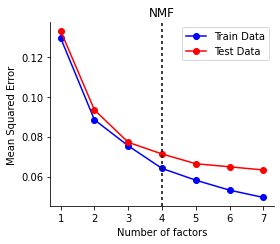

In [41]:
N, R = 150, 4
noise = .8
replicates = 1
ranks = np.arange(1, 8)

# initialize problem
U = np.random.rand(N, R)
Vt = np.random.rand(R, N)
data = X
train_err, test_err = [], []

# fit models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))

# make plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of factors')
ax.set_title('NMF')
ax.axvline(4, color='k', dashes=[2,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()

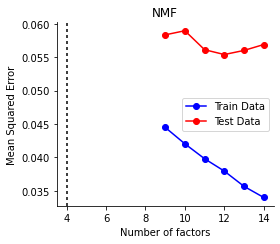

In [42]:
N, R = 150, 4
noise = .8
replicates = 1
ranks = np.arange(9, 15)

# initialize problem
U = np.random.rand(N, R)
Vt = np.random.rand(R, N)
data = X
train_err, test_err = [], []

# fit models
for rnk, _ in itertools.product(ranks, range(replicates)):
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))

# make plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ax.plot(*list(zip(*train_err)), 'o-b', label='Train Data')
ax.plot(*list(zip(*test_err)), 'o-r', label='Test Data')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of factors')
ax.set_title('NMF')
ax.axvline(4, color='k', dashes=[2,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()

In [44]:
W, H, info = NMF_HALS().run(X, 12,max_iter=None,)

[NMF] Running: 
{
    "A_dim_1": 683,
    "A_dim_2": 168,
    "A_type": "<class 'numpy.ndarray'>",
    "alg": "<class 'nonnegfac.nmf.NMF_HALS'>",
    "init": "uniform_random",
    "k": 12,
    "max_iter": 100,
    "max_time": Infinity,
    "verbose": 0
}
[NMF] Completed: 
{
    "elapsed": 0.13100552558898926,
    "iterations": 100,
    "norm_A": 848.4742080335567,
    "rel_error": 0.08201121680414108
}


In [48]:
W.shape

(683, 12)

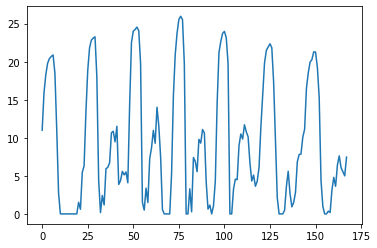

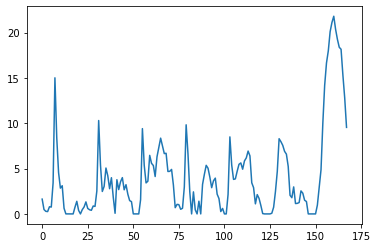

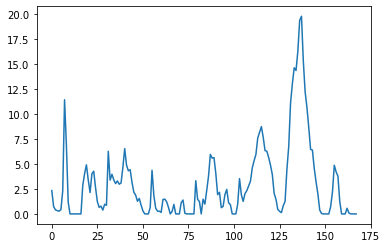

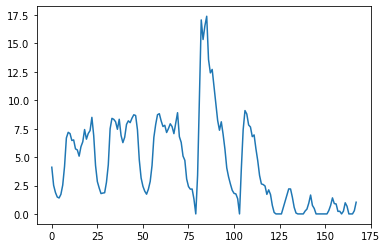

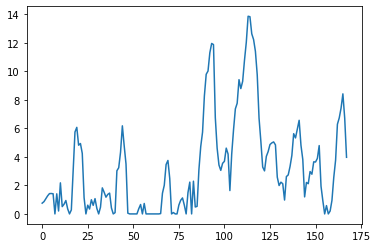

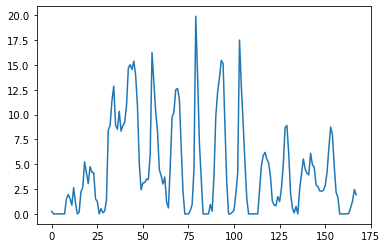

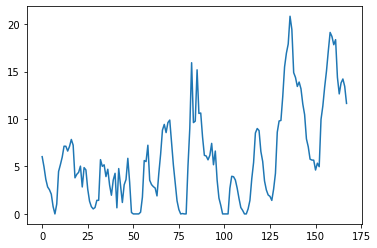

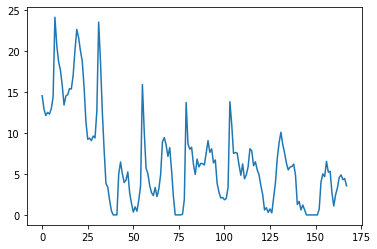

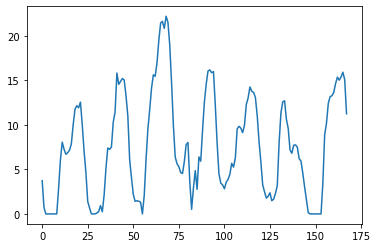

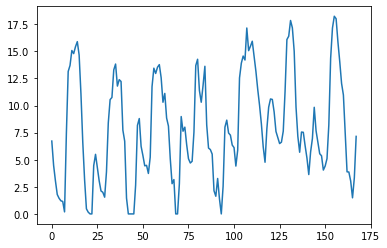

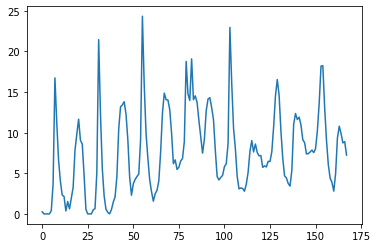

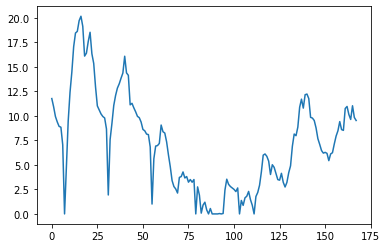

In [53]:
for i in range(12):
    plt.plot(H.T[i])
    plt.show()

In [71]:
p_holdout = 0.3
masking_matrix = np.random.rand(*X.shape) > p_holdout
masked_X = X.copy()
masked_X[masking_matrix] = None

In [72]:
# masked_X

In [73]:
tmp_nmf.fit(masked_X,)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [64]:
X_re = tmp_nmf.transform(X)

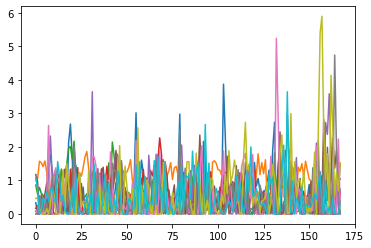

In [66]:
plt.plot(tmp_nmf.components_.T)

# Cross validation implementation

In [69]:
def make_mask(X,p_holdout = 0.3):
    masking_matrix = np.random.rand(*X.shape) > p_holdout
    return masking_matrix

p_holdout = 0.3

masks = []

# Create folds
for i in range(5):
    masks.append(make_mask(X,p_holdout))
    

for fold in range(5):
    tmp_mask = masks[fold]
    
    X_holdout = X.copy()
    X_holdout[tmp_mask]
    print(X_holdout)

[1.395007   1.057227   0.9414779  ... 2.87054891 2.36096079 1.75999199]
[1.395007   1.057227   0.9279785  ... 2.87054891 2.36096079 1.75999199]
[0.9414779  2.866738   1.818522   ... 2.10424536 2.59997358 2.87054891]
[1.057227   0.8922037  0.9279785  ... 2.59997358 2.87054891 1.75999199]
[1.395007   1.057227   0.9414779  ... 2.10424536 2.59997358 1.75999199]
